In [ ]:
!pip install kiwipiepy
!pip install WebOb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 7.0 MB/s 
     |████████████████████████████████| 27.7 MB 95.2 MB/s 
  Created wheel for kiwipiepy-model: filename=kiwipiepy_model-0.12.0-py3-none-any.whl size=27789677 sha256=78c0281f23d007673fe5f069f265df65605834520548882c43e71448c9f67acd
  Stored in directory: /root/.cache/pip/wheels/da/30/65/0934400fe1c12633da117d661b7795ea83c2a224ddc71fb72e
Successfully built kiwipiepy-model
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 114 kB 5.9 MB/s 


In [ ]:
import json, os, re, requests, sys, time
import pandas as pd
import numpy as np
import logging
import logging.handlers

from dateutil.relativedelta import relativedelta

from bs4 import BeautifulSoup as bs
from urllib.request import urlopen, Request
from datetime import date, datetime, timedelta
# from pykrx import stock
from webob.compat import urlparse
import lxml

from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import CoherenceMetric
from gensim import corpora
from gensim.models.callbacks import PerplexityMetric
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import matplotlib.pyplot as plt
import pickle

URL_NAVER_NEWS_QUERY = "https://search.naver.com/search.naver?where=news&query=%s&sm=tab_opt&pd=3&ds=%s&de=%s&start=%s"

In [ ]:
class NaverNewsCrawler:
    def __init__(self):
        self.ticker = None
        self.result = []
        pass

    def _crawl_by_query(self, ticker, s_date, e_date):

        q=""
        for c in ticker.encode("UTF-8"):
            q += "%%%s" % format(c, "x").upper()
        print(q)

        # 최대페이지(입력)까지 loop 돌면서 뉴스 가져오기(네이버뉴스가 없는 페이지가 있기때문)
        page = 1
        n_news = 0
        maxpage = 10

        while True:
            if page <= maxpage:
                page_t = (lambda x: (x-1)*10+1)(page)
                r_url = URL_NAVER_NEWS_QUERY % (q, s_date, e_date, page_t,)
                r = requests.get(r_url)
                soup = bs(r.text, 'lxml')
                news = soup.find('div', class_='group_news').find("ul",class_="list_news")
                
                # 마지막 페이지 찾기
                paging = soup.find('div', class_='sc_page_inner')
                paging_list = []
                for i in paging:
                    paging_list.append(i.text)
                    maxpage = int(paging_list[-1])
                
                # print(f'maxpage : {maxpage}')

                for urls in news.find_all("a", {"class": "info"}):
                    urls.get('href')
                    if urls['href'].startswith("https://news.naver.com"):
                        n_url = urls['href']
                        res = self._crawl_content(n_url)
                        self.result.append(res)
                        n_news += 1
                        time.sleep(1)
                page += 1
                if page % 10 == 0: 
                    print(f'page : {page} of {maxpage}')
                    print('url =',r_url)
            else:
                break

        print("number of news for comp {} = {}".format(ticker, n_news))

      
    def _crawl_content(self, n_url):

        try:
            r = requests.get(n_url, headers={'User-Agent':'Mozilla/5.0'})
            soup = bs(r.text,'lxml')
            # 제목
            news_title = soup.find('h2', class_='media_end_head_headline').text
            # 기사일자
            pdate = soup.find('span',class_='media_end_head_info_datestamp_time _ARTICLE_DATE_TIME').text[:10]
            # news_detail.append(pdate)
            # 본문
            origin_content = soup.find('div', class_='newsct_article _article_body')
            cntnt = origin_content.get_text().replace('\n', " ").strip('\t\r\n')        
            cntnt = re.sub('<script.*?>.*?</script>', '',str(cntnt),0,re.I|re.S)
            cntnt = re.sub('<!-- .*? -->', '', str(cntnt), 0, re.I|re.S)
            cntnt = re.sub('▶.*', '', str(cntnt), 0, re.I|re.S)
            content = re.sub('<.+?>', '',str(cntnt), 0).strip()
            # 기사링크
            url = n_url
            # 기사ID
            # p = urlparse.parse_qs(urlparse.urlparse(url).query)
            # article_id = p['mode'][0]+p['mid'][0]+p['sid1'][0]+p['oid'][0]+p['aid'][0]
            # 언론사
            # pcompany = soup.select('#footer address')[0].a.get_text()

            return {"title":news_title, "date":pdate, "contents":content, "url":url}
        except Exception as e:
            pass


    def get_news(self, ticker, s_date, e_date):
        # logger instance 생성
        logger = logging.getLogger(__name__)
        
        # Check handler exists
        # if len(logger.handlers) > 0:
        #     return logger # Logger already exists
               
        # Format 설정
        formatter = logging.Formatter(
            "%(asctime)s %(levelname)s [%(name)s] [%(filename)s:%(lineno)d] - %(message)s"
        )
        
        # handler 생성
        streamHandler = logging.StreamHandler()
        streamHandler.setFormatter(formatter)
        
        logger.addHandler(streamHandler)
        logger.setLevel(level=logging.INFO)
        
        today = datetime.today().strftime("%Y.%m.%d")
        print(f'today= {today}')
        
        if s_date is None:
            s_date = today
        else:
            s_date = s_date

        if e_date is None:
            e_date = today
        else:
            e_date = e_date
                    
        for i, ticker in enumerate([ticker]):
            logger.info("i = {}, text = {}".format(i, ticker))
            try:
                msg = "text = {}".format(ticker)
                logger.info(msg)
                time.sleep(1)
                self._crawl_by_query(ticker=ticker, s_date=s_date, e_date=e_date)
            except Exception as e:
                logger.error(e)
                pass

In [ ]:
# 데이터 수집 실행

NNC = NaverNewsCrawler()

last_dt = '2022.06.01'
last_date = pd.to_datetime(last_dt, format='%Y-%m-%d')

start_dt = '2022.05.28'
start_date = pd.to_datetime(start_dt, format='%Y-%m-%d')

end_dt = '2022.05.29'
end_date = pd.to_datetime(end_dt, format='%Y-%m-%d') 

d = timedelta(days=1)

while end_date <= last_date:
    print(f'======> start batch date: {start_dt} ~ {end_dt}')
    NNC.get_news('이더리움', start_dt, end_dt)

    start_date = pd.to_datetime(start_dt, format='%Y-%m-%d')

    start_date += relativedelta(months=1)
    end_date = pd.to_datetime(start_date + relativedelta(months=1)  - d, format='%Y-%m-%d')

    start_dt = start_date.strftime('%Y.%m.%d')
    end_dt = end_date.strftime('%Y.%m.%d')

2022-05-29 14:54:14,443 INFO [__main__] [<ipython-input-41-85cd152da0cd>:118] - i = 0, text = 이더리움
2022-05-29 14:54:14,444 INFO [__main__] [<ipython-input-41-85cd152da0cd>:121] - text = 이더리움


======> start batch date: 2022.05.28 ~ 2022.05.29
today= 2022.05.29
%EC%9D%B4%EB%8D%94%EB%A6%AC%EC%9B%80
number of news for comp 이더리움 = 12


In [ ]:
result = [x for x in NNC.result if x is not None]
news_text = pd.DataFrame(result)
news_text = news_text[['date','title','url','contents']]

element_count = {}

for item in news_text['date']:
    element_count.setdefault(item,0)
    element_count[item] += 1

news_count = pd.DataFrame.from_dict(element_count, orient = 'index',columns=["news_count"])
news_count = news_count.sort_index(ascending=False)
news_count

,news_count
2022.05.28,9
2022.05.27,34
2022.05.26,33
2022.05.25,48
2022.05.24,54
...,...
2020.05.05,22
2020.05.04,27
2020.05.03,22
2020.05.02,12


In [ ]:
series_news = news_text.groupby('date')['contents'].apply(lambda x: x.sum())
df = pd.DataFrame(series_news).sort_values(by='date', ascending=False).reset_index()
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df.to_csv("/content/drive/MyDrive/Colab Notebooks/실무인증/news_202005_202205_20220527-1.csv", index=False, encoding="utf-8-sig")
df.head()

In [ ]:
# 데이터 불러오기 

# x = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/실무인증/Data/news_2017_202004_20220527-1.csv')
# y = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/실무인증/Data/news_202005_202205_20220527-1.csv')
# x = x.loc[x['date'].str[0:7] != '2020-05']
# z = pd.concat([x, y], axis=0)
# df = z.sort_values(by='date', ascending=False).reset_index(drop=True)
# df.head()

In [ ]:
#데이터 프레임의 'text' 열의 값들을 str 형식으로 변환
df.contents = df.contents.astype(str)

#contents date 열을 기준으로 중복된 데이터를 삭제
df_news = df.drop_duplicates(subset=['date','contents'])

#한글이 아니면 빈 문자열로 바꾸기
df_news['contents'] = df_news['contents'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ',regex=True)

#빈 문자열 NAN 값으로 바꾸기
df_news = df_news.replace({'': np.nan})
df_news = df_news.replace(r'^\s*$', None, regex=True)

#NAN 이 있는 행은 삭제
df_news = df_news.dropna(how='any')

#인덱스
df_news = df_news.reset_index (drop = True)

#데이터 프레임에 null값 확인
print(df_news.isnull().values.any()) 

False


In [ ]:
df_news

,date,contents
0,2022-05-28,편집자주암호화폐와 가상자산은 금융의 미래일까 도박 같은 거품일까 블록체인 비트...
1,2022-05-27,파이낸셜뉴스 한동안 나스닥과 동조현상을 보이던 가상자산 시장이 최근에는 나스닥 ...
2,2022-05-26,출처 코인니스 데이터 처음으로 온체인 거래량 추월...
3,2022-05-25,세대 거래액 비중 전체의 여성 거래액 비중 로 전년 ...
4,2022-05-24,파이낸셜뉴스 프랑스 명품 브랜드 발렌시아가 가 비트코인 ...
...,...,...
1597,2017-05-08,차세대 가상화폐로 부상하고 있는 이더리움 사진 출처 코인원 한동안 비트코인이...
1598,2017-05-06,아이뉴스 편집국 대선을 코앞에 두고 지난 일 이틀간 진행된 사전...
1599,2017-05-04,아이뉴스 김국배기자 이 블록체인 기술 상용화를 위...
1600,2017-05-03,비트코인 개 만원 돌파 투자 대상 넘어 결제 수단 사용 늘어 가격 변동성...


In [ ]:
len(df_news)

1602

In [ ]:
from kiwipiepy import Kiwi

kiwi = Kiwi()
kiwi.prepare()

#텍스트 데이터를 리스트로 변환
data_list=df_news.contents.values.tolist()

#리스트를 요소별로 가져와서 명사만 추출한 후 리스트로 저장
data_word=[]
for i in range(len(data_list)):
    result = kiwi.analyze(data_list[i])
    word=[]
    for token, pos, _, _ in result[0][0]:
        if pos.startswith('N'):
            word.append(token)
    data_word.append(word)

#명사만 추출해서 만든 리스트
#print(data_word)

Number of unique tokens: 16032
Number of documents: 1602
Num Topics = 2  has Coherence Value of 0.35143247871594063
Num Topics = 8  has Coherence Value of 0.2717816676397191
Num Topics = 14  has Coherence Value of 0.2763371527210255
Num Topics = 20  has Coherence Value of 0.2997077350843994
Num Topics = 26  has Coherence Value of 0.2935880730356071
Num Topics = 32  has Coherence Value of 0.28520712981454965
Num Topics = 38  has Coherence Value of 0.26093270008896274


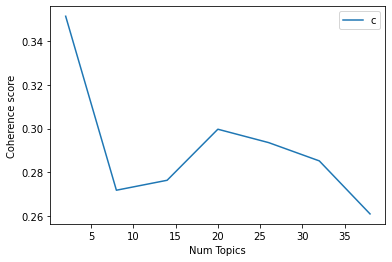

In [ ]:
# 토픽 수 별로 일관성 점수를 계산해서 가장 좋은 토픽 수의 모델 찾기
# 가장 좋은 토픽 개수를 찾기 위해 coherence를 c_v로 계산하여 좋은 LDA 모델 찾기

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


# 정수 인코딩과 빈도수 생성
dictionary = Dictionary(data_word)

# 출현빈도가 적거나 자주 등장하는 단어는 제거
dictionary.filter_extremes(no_below = 5, no_above = 0.5) #5회 이하로 등장한 단어는 삭제

corpus = []

for doc in data_word:
    bow = dictionary.doc2bow(doc)
    corpus.append(bow)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

# 최적의 토픽 수 찾기 : coherence를 계산시 토픽의 개수를 2~40개 사이로 6 step으로 나누어 진행

limit = 40;
start = 2;
step = 6;

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=data_word, start=start, limit=limit, step=step)

x = range(start, limit, step)
topic_num = 0
count = 0
max_coherence = 0

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", cv)
    coherence = cv
    if coherence >= max_coherence:
        max_coherence = coherence
        topic_num = m
        model_list_num = count   
    count = count+1

optimal_model = model_list[model_list_num]
model_topics = optimal_model.show_topics(formatted=False)


# 그래프
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [ ]:
# 최적의 토픽 수 20개로 모델 학습

perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')
coherence_logger = CoherenceMetric(corpus=corpus, coherence="u_mass", logger='shell')

lda_model = LdaModel(corpus, id2word=dictionary, num_topics=20, passes=30, callbacks=[coherence_logger, perplexity_logger])

# topics = lda_model.print_topics(num_words=5)
# for topic in topics:
#     print(topic)

# Compute Coherence Score using c_v
coherence_model_lda_cv = CoherenceModel(model=lda_model, texts=data_word, dictionary=dictionary, coherence='c_v')
coherence_lda_cv = coherence_model_lda_cv.get_coherence()
print('\nCoherence Score (c_v): ', coherence_lda_cv)

# Compute Coherence Score using UMass
coherence_model_lda_u_mass = CoherenceModel(model=lda_model, texts=data_word, dictionary=dictionary, coherence="u_mass")
coherence_lda_u_mass = coherence_model_lda_u_mass.get_coherence()
print('\nCoherence Score (u_mass): ', coherence_lda_u_mass)


# 저장
pickle.dump(corpus, open('/content/drive/MyDrive/Colab Notebooks/실무인증/lda_corpus.pkl', 'wb'))
dictionary.save('/content/drive/MyDrive/Colab Notebooks/실무인증/lda_dictionary.gensim')
lda_model.save('/content/drive/MyDrive/Colab Notebooks/실무인증/lda_model.gensim')



Coherence Score (c_v):  0.5712605163268841

Coherence Score (u_mass):  -0.7390089899411727


In [ ]:
# 데이터프레임 만들기

def format_topics_sentences(ldamodel, corpus, texts):

    sent_topics_df = pd.DataFrame()

    #ldamodel[corpus]: lda_model에 corpus를 넣어 각 토픽 당 확률을 알 수 있음
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num,topn=10)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    print(type(sent_topics_df))

    sent_topics_df = pd.concat([sent_topics_df, df_news['contents'],df_news['date']], axis=1)
    return(sent_topics_df)



df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_list)

# Format
df_topic_news = df_topic_sents_keywords.reset_index()
df_topic_news.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'contents','date']

df_topic_news['Dominant_Topic'] = df_topic_news['Dominant_Topic'] +1
df_topic_news.Dominant_Topic = df_topic_news.Dominant_Topic.astype(str)
df_topic_news['Dominant_Topic'] = df_topic_news['Dominant_Topic'].str.split('.').str[0]

<class 'pandas.core.frame.DataFrame'>


In [ ]:
df_topic_news

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,contents,date
0,0,11,0.9356,"테라, 루나, 폭락, 클레이튼, 사태, 스테이블코, 권, 지수, 바이낸스, 스테이블",편집자주암호화폐와 가상자산은 금융의 미래일까 도박 같은 거품일까 블록체인 비트...,2022-05-28
1,1,11,0.7880,"테라, 루나, 폭락, 클레이튼, 사태, 스테이블코, 권, 지수, 바이낸스, 스테이블",파이낸셜뉴스 한동안 나스닥과 동조현상을 보이던 가상자산 시장이 최근에는 나스닥 ...,2022-05-27
2,2,11,0.5273,"테라, 루나, 폭락, 클레이튼, 사태, 스테이블코, 권, 지수, 바이낸스, 스테이블",출처 코인니스 데이터 처음으로 온체인 거래량 추월...,2022-05-26
3,3,11,0.7844,"테라, 루나, 폭락, 클레이튼, 사태, 스테이블코, 권, 지수, 바이낸스, 스테이블",세대 거래액 비중 전체의 여성 거래액 비중 로 전년 ...,2022-05-25
4,4,11,0.6868,"테라, 루나, 폭락, 클레이튼, 사태, 스테이블코, 권, 지수, 바이낸스, 스테이블",파이낸셜뉴스 프랑스 명품 브랜드 발렌시아가 가 비트코인 ...,2022-05-24
...,...,...,...,...,...,...
1597,1597,15,0.7289,"투기, 인터넷, 일본, 해킹, 보안, 계약, 분산, 컴퓨터, 교수, 제도",차세대 가상화폐로 부상하고 있는 이더리움 사진 출처 코인원 한동안 비트코인이...,2017-05-08
1598,1598,19,0.3944,"지수, 작품, 금리, 메타버스, 경매, 연준, 인상, 증시, 판매, 게임",아이뉴스 편집국 대선을 코앞에 두고 지난 일 이틀간 진행된 사전...,2017-05-06
1599,1599,14,0.7712,"개발자, 부테린, 보안, 넷, 스마트, 증명, 처리, 솔루션, 컨트랙트, 포크",아이뉴스 김국배기자 이 블록체인 기술 상용화를 위...,2017-05-04
1600,1600,15,0.7742,"투기, 인터넷, 일본, 해킹, 보안, 계약, 분산, 컴퓨터, 교수, 제도",비트코인 개 만원 돌파 투자 대상 넘어 결제 수단 사용 늘어 가격 변동성...,2017-05-03


In [ ]:
# DataFrame 저장
df_topic_news.to_csv ("/content/drive/MyDrive/Colab Notebooks/실무인증/df_topic_news_20220528.csv", index = None)

In [ ]:
#토픽별 뉴스 저장
for i in range(1,21):
    globals()['df_{}'.format(i)]=df_topic_news.loc[df_topic_news.Dominant_Topic==str(i)]
    globals()['df_{}'.format(i)].sort_values('Topic_Perc_Contrib',ascending=False,inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
df_11

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,contents,date
15,15,11,0.9770,"테라, 루나, 폭락, 클레이튼, 사태, 스테이블코, 권, 지수, 바이낸스, 스테이블",리플 비트코인 이더리움 라이트코인 등 가상화폐 이미지 로이터 연합뉴스 ...,2022-05-13
7,7,11,0.9640,"테라, 루나, 폭락, 클레이튼, 사태, 스테이블코, 권, 지수, 바이낸스, 스테이블",비트코인 가격 소폭 반등했지만 만원선 못 넘어 루나 사태 합수단 호 ...,2022-05-21
0,0,11,0.9356,"테라, 루나, 폭락, 클레이튼, 사태, 스테이블코, 권, 지수, 바이낸스, 스테이블",편집자주암호화폐와 가상자산은 금융의 미래일까 도박 같은 거품일까 블록체인 비트...,2022-05-28
10,10,11,0.9192,"테라, 루나, 폭락, 클레이튼, 사태, 스테이블코, 권, 지수, 바이낸스, 스테이블",테라 연 이자율은 바보 같은 말 손실 본 투자자들 집단 소송 움직임금융위 ...,2022-05-18
11,11,11,0.8697,"테라, 루나, 폭락, 클레이튼, 사태, 스테이블코, 권, 지수, 바이낸스, 스테이블",테라폼랩스의 수익률 제공 주장은 다단계 금융사기 가상화폐 이더리...,2022-05-17
16,16,11,0.8652,"테라, 루나, 폭락, 클레이튼, 사태, 스테이블코, 권, 지수, 바이낸스, 스테이블",연준 금리 인상 국내 코인 폭락 등이 주요 원인으로 비트코인이 미국 금리인상...,2022-05-12
12,12,11,0.8422,"테라, 루나, 폭락, 클레이튼, 사태, 스테이블코, 권, 지수, 바이낸스, 스테이블",백훈종의 알쓸 잡 월 일 한국경제신문의 암호화폐 투자 뉴스레터 ...,2022-05-16
934,934,11,0.7954,"테라, 루나, 폭락, 클레이튼, 사태, 스테이블코, 권, 지수, 바이낸스, 스테이블",한국 블록체인 기업들 둥지 옮기기 본격화 이더리움 수수료 누린 정보처리 속도에 ...,2019-07-21
1,1,11,0.7880,"테라, 루나, 폭락, 클레이튼, 사태, 스테이블코, 권, 지수, 바이낸스, 스테이블",파이낸셜뉴스 한동안 나스닥과 동조현상을 보이던 가상자산 시장이 최근에는 나스닥 ...,2022-05-27
3,3,11,0.7844,"테라, 루나, 폭락, 클레이튼, 사태, 스테이블코, 권, 지수, 바이낸스, 스테이블",세대 거래액 비중 전체의 여성 거래액 비중 로 전년 ...,2022-05-25
